In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!which python

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from retDNN import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import scipy.stats as ss

def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2*c + 1)
    return ss.norm.ppf(x)

def rank_INT(series, c=3.0/8, stochastic=True):
    """ Perform rank-based inverse normal transformation on pandas series.
        If stochastic is True ties are given rank randomly, otherwise ties will
        share the same value. NaN values are ignored.
        Args:
            param1 (pandas.Series):   Series of values to transform
            param2 (Optional[float]): Constand parameter (Bloms constant)
            param3 (Optional[bool]):  Whether to randomise rank of ties
        
        Returns:
            pandas.Series
    """

    # Check input
    #assert(isinstance(series, pd.Series))
    #assert(isinstance(c, float))
    #assert(isinstance(stochastic, bool))

    # Set seed
    np.random.seed(123)

    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))
    
    return transformed[orig_idx]

In [5]:
df = pd.read_excel('Eco1_ncRNAs_with_scores_r2L2_extraQfilter.xlsx')
df = df.loc[~np.isnan(df['Score (enrichment/depletion relative to mean wt, wt=100)']),]
df['score'] = df['Score (enrichment/depletion relative to mean wt, wt=100)'].apply(lambda x: np.log2(x+0.001))
df['length'] = df['ncRNA'].apply(lambda x: len(x))
df.index = ["item_{}".format(x+1) for x in df.index]
df.head()

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length
item_1,r1,L7,4235,86_r1_L7,1.219663,0.544209,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.287665,119
item_2,r1,L7,4236,86_r1_L7,0.244852,0.214515,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,-2.024137,121
item_3,r1,L7,4237,86_r1_L7,1.884223,1.060321,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.914735,123
item_4,r1,L7,4238,86_r1_L7,6.821973,3.187198,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.770400,125
item_5,r1,L7,4239,86_r1_L7,6.150030,2.305129,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.620828,127


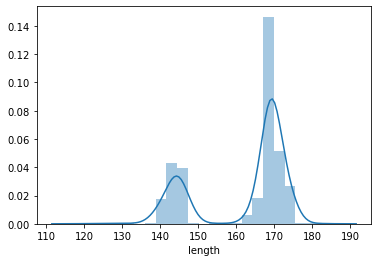

In [6]:
sns.distplot(df.length)

In [7]:
df.length.max()

184

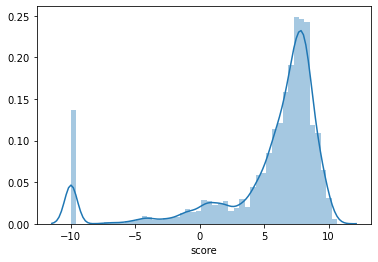

In [8]:
sns.distplot(df['score'])

In [9]:
df['scoreINT'] = rank_INT(df['score'])

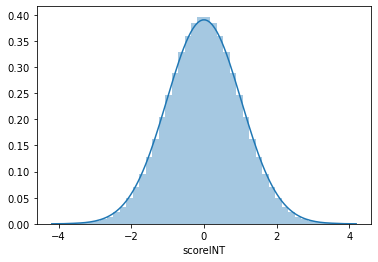

In [10]:
import seaborn as sns
sns.distplot(df['scoreINT'])

In [11]:
df.to_csv("Eco1_ncRNAs_with_scores_processed.tsv", sep="\t")

In [11]:
df.head()

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length,scoreINT
item_1,r1,L7,4235,86_r1_L7,1.219663,0.544209,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.287665,119,-1.205478
item_2,r1,L7,4236,86_r1_L7,0.244852,0.214515,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,-2.024137,121,-1.400132
item_3,r1,L7,4237,86_r1_L7,1.884223,1.060321,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.914735,123,-1.120598
item_4,r1,L7,4238,86_r1_L7,6.821973,3.187198,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.770400,125,-0.942509
item_5,r1,L7,4239,86_r1_L7,6.150030,2.305129,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.620828,127,-0.950524


In [12]:
seq_dict = dict(zip(df.index,df.ncRNA))
score_dict = dict(zip(df.index,df.scoreINT))

In [13]:
dict(list(seq_dict.items())[0:5])

{'item_1': 'TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGATGTTGTTTCGGCATCCTGCATTGAATCTGAGTTACTGTCTGTGCCTCCCGTTTTTTCTGACGTAAGGGTGCGCA',
 'item_2': 'TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGATGTTGTTTCGGCATCCTGCATTGAATCTGAGTTACTGTCTGTTGCCTACCCGTTTTTTCTGACGTAAGGGTGCGCA',
 'item_3': 'TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGATGTTGTTTCGGCATCCTGCATTGAATCTGAGTTACTGTCTGTTTGCCTAACCCGTTTTTTCTGACGTAAGGGTGCGCA',
 'item_4': 'TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGATGTTGTTTCGGCATCCTGCATTGAATCTGAGTTACTGTCTGTTTTGCCTAAACCCGTTTTTTCTGACGTAAGGGTGCGCA',
 'item_5': 'TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGATGTTGTTTCGGCATCCTGCATTGAATCTGAGTTACTGTCTGTTTTCGCCTGAAACCCGTTTTTTCTGACGTAAGGGTGCGCA'}

In [14]:
dict(list(score_dict.items())[0:5])

{'item_1': -1.2054776236928761,
 'item_2': -1.4001315973248816,
 'item_3': -1.1205981412097246,
 'item_4': -0.942508929573089,
 'item_5': -0.9505240460888126}

In [16]:
## Split the data between train and test
import random
import numpy as np

test_index = np.array(random.sample(range(df.shape[0]), int(float(df.shape[0])*0.1)))
mask = np.zeros(df.shape[0],dtype=bool)
mask[test_index] = True

In [17]:
df_test = df[mask]
df_test.head()

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length,scoreINT
item_2,r1,L7,4236,86_r1_L7,0.244852,0.214515,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,-2.024137,121,-1.400132
item_11,r1,L7,4245,86_r1_L7,47.412226,5.632973,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,5.567218,139,-0.522093
item_16,r1,L7,4250,86_r1_L7,55.899669,13.984365,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,5.804794,149,-0.445592
item_28,r1,L7,4262,86_r1_L7,62.126424,1.624409,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,5.957158,173,-0.403955
item_44,r1,L10,5278,86_r1_L10,111.101818,5.293149,3,CGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGATGT...,6.795752,148,-0.108121


In [18]:
tmp_df = df[~mask]
valid_index = np.array(random.sample(range(tmp_df.shape[0]), int(float(tmp_df.shape[0])*0.05)))
mask = np.zeros(tmp_df.shape[0],dtype=bool)
mask[valid_index] = True

In [19]:
df_valid = tmp_df[mask]
df_train = tmp_df[~mask]

In [20]:
print(df_train.shape, df_valid.shape, df_test.shape)

(2930, 11) (154, 11) (342, 11)


In [21]:
df_train.to_csv('data/train.csv')
df_valid.to_csv('data/valid.csv')
df_test.to_csv('data/test.csv')

In [8]:
from retDNN import *
from torchsummary import summary

seq_length=200

In [23]:
train_data_loader = DataLoader(retDataset(df_train.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=32, shuffle=True, drop_last=True)
valid_data_loader = DataLoader(retDataset(df_valid.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

In [9]:
model = retDNNModel(max_len=seq_length)
print(model)

retDNNModel(
  (conv_block_1): Sequential(
    (0): Conv1d(4, 64, kernel_size=(10,), stride=(1,), padding=(10,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=10, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (dilations): ModuleList(
    (0): Sequential(
      (0): Conv1d(32, 4, kernel_size=(3,), stride=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): C

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [26]:
model.compile(device=device)

In [27]:
logfile = open('models/history.log', 'at', buffering=1)

In [28]:
hist = model.train_model(train_data_loader,val_loader=valid_data_loader, epochs=70, device=device, logfile=logfile)

Train Epoch: 0 [0/2930 (0%)]	Loss: 2.503191	R: 0.023833
Train Epoch: 0 [320/2930 (11%)]	Loss: 1.458141	R: 0.237567
Train Epoch: 0 [640/2930 (22%)]	Loss: 1.251241	R: 0.195768
Train Epoch: 0 [960/2930 (33%)]	Loss: 0.645586	R: 0.422830
Train Epoch: 0 [1280/2930 (44%)]	Loss: 0.754803	R: 0.489184
Train Epoch: 0 [1600/2930 (55%)]	Loss: 0.668963	R: 0.485346
Train Epoch: 0 [1920/2930 (66%)]	Loss: 0.391173	R: 0.634400
Train Epoch: 0 [2240/2930 (76%)]	Loss: 1.201048	R: 0.367370
Train Epoch: 0 [2560/2930 (87%)]	Loss: 1.121578	R: 0.297221
Train Epoch: 0 [2880/2930 (98%)]	Loss: 1.043807	R: 0.314831
Validation: Loss: 0.827610	R: 0.528630
Best model updated.
Train Epoch: 1 [0/2930 (0%)]	Loss: 1.137542	R: 0.386040
Train Epoch: 1 [320/2930 (11%)]	Loss: 1.156520	R: 0.177399
Train Epoch: 1 [640/2930 (22%)]	Loss: 0.606174	R: 0.475605
Train Epoch: 1 [960/2930 (33%)]	Loss: 0.915263	R: 0.569711
Train Epoch: 1 [1280/2930 (44%)]	Loss: 0.792305	R: 0.467425
Train Epoch: 1 [1600/2930 (55%)]	Loss: 0.634514	R: 0.34

In [29]:
hist_df = pd.DataFrame([hist['valid_loss'], hist['valid_Rs']]).T
hist_df.head()

,0,1
0,0.827610,0.528630
1,0.789835,0.528062
2,0.761933,0.534057
3,0.780216,0.530179
4,0.765739,0.530197


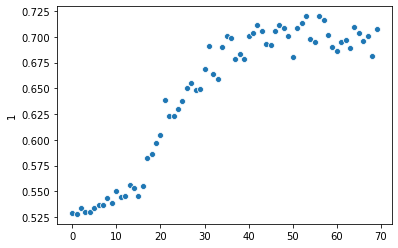

In [30]:
sns.scatterplot(hist_df.index.tolist(), hist_df.iloc[:,1])

In [31]:
test_data_loader = DataLoader(retDataset(df_test.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

In [32]:
model.eval()
target_list = []
pred_list = []
seq_id_list = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_data_loader):
        seqid,seq_X,y = batch
        seq_X = seq_X.to(device)
        y = y.to(device)
        out = model(seq_X)
        pred_list.append(out[:,0].to('cpu').detach().numpy())
        target_list.append(y.to('cpu').detach().numpy())
        seq_id_list.append(seqid)
    targets = np.concatenate(target_list)
    preds = np.concatenate(pred_list)
    seq_ids = np.concatenate(seq_id_list)

In [33]:
import scipy.stats as stats
stats.pearsonr(targets[:,0], preds)

(0.6628490958503446, 1.2245582421417112e-44)

In [34]:
test_df = pd.DataFrame(zip(targets[:,0], preds))
test_df.columns = ['targets', 'preds']
test_df.index = seq_ids
test_df.head()

,targets,preds
item_2,-1.400132,-0.590451
item_11,-0.522093,-0.575691
item_16,-0.445592,-0.338532
item_28,-0.403955,0.068740
item_44,-0.108121,-0.108257


In [35]:
test_df.to_hdf('data/test_pred.df.h5', key='data')

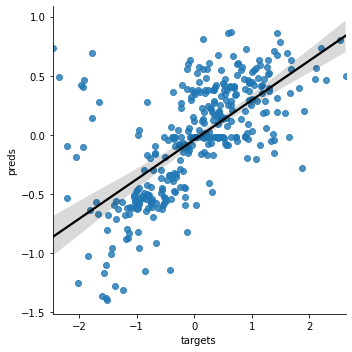

In [36]:
import seaborn as sns
plot = sns.lmplot('targets', 'preds', test_df, line_kws={'color': 'black'})
#plot = sns.jointplot('targets', 'preds', test_df, kind="kde", ylim=(-5, 5))
#plot.set()

### Hyperparameter Optimization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from retDNN import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [4]:
df = pd.read_csv("Eco1_ncRNAs_with_scores_processed.tsv", sep="\t", index_col=0)
df.head(n=1)

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length,scoreINT
item_1,r1,L7,4235,86_r1_L7,1.219663,0.544209,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.287665,119,-1.205478


In [15]:
seq_dict = dict(zip(df.index,df.ncRNA))
score_dict = dict(zip(df.index,df.scoreINT))

In [16]:
df_train = pd.read_csv('data/train.csv', index_col=0, header=0)
df_valid = pd.read_csv('data/valid.csv', index_col=0, header=0)
df_test = pd.read_csv('data/test.csv', index_col=0, header=0)
print(df_train.shape, df_valid.shape, df_test.shape)

(2930, 11) (154, 11) (342, 11)


In [17]:
from retDNN import *
from torchsummary import summary

seq_length=300

In [8]:
def train_cifar(config, checkpoint_dir=None):
    train_data_loader = DataLoader(retDataset(df_train.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=config["batch_size"], shuffle=True, drop_last=True)
    valid_data_loader = DataLoader(retDataset(df_valid.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=config["batch_size"], shuffle=False, drop_last=False)
    
    if torch.cuda.is_available():
        device = torch.device("cuda") 
    else:
        device = torch.device("cpu")

    model = retDNNModel(max_len=seq_length,
                 conv1kc=config["conv1kc"], conv1ks=config["conv1ks"], conv1st=1, conv1pd=config["conv1ks"], pool1ks=config["pool1ks"], pool1st=config["pool1st"] , pdrop1=config["pdrop1"], #conv_block_1 parameters
                 conv2kc=config["conv2kc"], conv2ks=config["conv2ks"], conv2st=1, conv2pd=config["conv2ks"], pool2ks=config["pool2ks"], pool2st=config["pool2st"] , pdrop2=config["pdrop2"], #conv_block_2 parameters
                 convdc =config["convdc"], convdkc=config["convdkc"] , convdks=config["convdks"] , #dilation block parameters
                 fchidden =config["fchidden"], pdropfc=config["pdropfc"], final=1, #fully connected parameters

                 opt="Adam", loss="mse", lr=config["lr"], momentum=0.9, weight_decay=1e-3
                 )
    model.compile(device=device)
    
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        model.load_state_dict(model_state)
        model.optimizer.load_state_dict(optimizer_state)
        
    hist = model.train_model(train_data_loader,val_loader=valid_data_loader, epochs=50, device=device, modelfile=None, tuneray=True, verbose=False)

In [9]:
import scipy.stats as stats
    
def test_accuracy(net, device="cpu"):
    model.eval()
    target_list = []
    pred_list = []
    seq_id_list = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_data_loader):
            seqid,seq_X,y = batch
            seq_X = seq_X.to(device)
            y = y.to(device)
            out = model(seq_X)
            pred_list.append(out[:,0].to('cpu').detach().numpy())
            target_list.append(y.to('cpu').detach().numpy())
            seq_id_list.append(seqid)
        targets = np.concatenate(target_list)
        preds = np.concatenate(pred_list)
        seq_ids = np.concatenate(seq_id_list)
    return stats.pearsonr(targets[:,0], preds)[0]

In [10]:
config = {
    #"l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    #"l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([16, 32, 64]),
    
    "conv1kc": tune.choice([16, 32, 64]),
    "conv2kc": tune.choice([16, 32, 64]),
    
    "conv1ks": tune.choice([5, 10, 15]),
    "conv2ks": tune.choice([3, 5]),
    
    "pool1ks": tune.choice([5, 10]),
    "pool2ks": tune.choice([5]),

    "pool1st": tune.choice([5]),
    "pool2st": tune.choice([5]),
    
    "pdrop1": tune.choice([0.1,0.25,0.5]),
    "pdrop2": tune.choice([0.1,0.25,0.5]),
    
    "convdc": tune.choice([2,3]),
    "convdkc":tune.choice([4,8]),
    "convdks":tune.choice([3]),
    
    "fchidden": tune.choice([10,32]),
    "pdropfc":  tune.choice([0.25,0.5]),
}

In [ ]:
from functools import partial

scheduler = ASHAScheduler(
                            metric="loss",
                            mode="min",
                            max_t=50,
                            grace_period=1,
                            reduction_factor=2)

reporter = CLIReporter(
        metric_columns=["loss", "corel", "training_iteration"])

result = tune.run(
    partial(train_cifar),
    resources_per_trial={"cpu": 4, "gpu": 1},
    config=config,
    num_samples=100,
    scheduler=scheduler,
    progress_reporter=reporter)

In [19]:
logfile = open('models/history.log', 'at', buffering=1)

In [20]:
seq_length

300

In [21]:
#Best model
train_data_loader = DataLoader(retDataset(df_train.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=64, shuffle=True, drop_last=True)
valid_data_loader = DataLoader(retDataset(df_valid.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=64, shuffle=False, drop_last=False)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model = retDNNModel(max_len=seq_length,
             conv1kc=64, conv1ks=10, conv1st=1, conv1pd=10, pool1ks=10, pool1st=5 , pdrop1=0.1,#conv_block_1 parameters
             conv2kc=16, conv2ks=5,  conv2st=1, conv2pd=5,  pool2ks=5,  pool2st=5 , pdrop2=0.1, #conv_block_2 parameters
             convdc =2, convdkc=8 , convdks=3 , #dilation block parameters
             fchidden =32, pdropfc=0.25, final=1, #fully connected parameters

             opt="Adam", loss="mse", lr=0.0036797, momentum=0.9, weight_decay=1e-3
             )
model.compile(device=device)

hist = model.train_model(train_data_loader,val_loader=valid_data_loader, epochs=120, device=device, logfile=logfile)

Train Epoch: 0 [0/2930 (0%)]	Loss: 1.360561	R: 0.085845
Train Epoch: 0 [640/2930 (22%)]	Loss: 0.924268	R: 0.321700
Train Epoch: 0 [1280/2930 (44%)]	Loss: 0.649989	R: 0.474911
Train Epoch: 0 [1920/2930 (66%)]	Loss: 0.984058	R: 0.450105
Train Epoch: 0 [2560/2930 (87%)]	Loss: 0.658844	R: 0.457145
Validation: Loss: 0.760720	R: 0.531240
Best model updated.
Train Epoch: 1 [0/2930 (0%)]	Loss: 0.470625	R: 0.590215
Train Epoch: 1 [640/2930 (22%)]	Loss: 1.014288	R: 0.471108
Train Epoch: 1 [1280/2930 (44%)]	Loss: 0.840981	R: 0.433917
Train Epoch: 1 [1920/2930 (66%)]	Loss: 1.041892	R: 0.432984
Train Epoch: 1 [2560/2930 (87%)]	Loss: 0.779010	R: 0.537174
Validation: Loss: 0.750375	R: 0.542456
Best model updated.
Train Epoch: 2 [0/2930 (0%)]	Loss: 0.537271	R: 0.696732
Train Epoch: 2 [640/2930 (22%)]	Loss: 0.654851	R: 0.507983
Train Epoch: 2 [1280/2930 (44%)]	Loss: 0.984519	R: 0.548253
Train Epoch: 2 [1920/2930 (66%)]	Loss: 1.032475	R: 0.308511
Train Epoch: 2 [2560/2930 (87%)]	Loss: 0.450814	R: 0.6557

In [22]:
hist_df = pd.DataFrame([hist['valid_loss'], hist['valid_Rs']]).T
hist_df.head()

,0,1
0,0.760720,0.531240
1,0.750375,0.542456
2,0.719611,0.546535
3,0.703845,0.561877
4,0.721204,0.555944


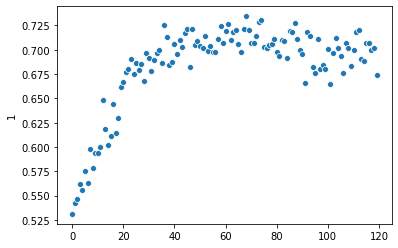

In [23]:
sns.scatterplot(hist_df.index.tolist(), hist_df.iloc[:,1])

In [24]:
model.save_model('models/final_tuned_model.pt')

In [25]:
!mv models/best_ret_checkpoint.pt models/best_tuned_model.pt 

In [26]:
model.load_model('models/best_tuned_model.pt')

In [27]:
import scipy.stats as stats

test_data_loader = DataLoader(retDataset(df_test.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

model.eval()
target_list = []
pred_list = []
seq_id_list = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_data_loader):
        seqid,seq_X,y = batch
        seq_X = seq_X.to(device)
        y = y.to(device)
        out = model(seq_X)
        pred_list.append(out[:,0].to('cpu').detach().numpy())
        target_list.append(y.to('cpu').detach().numpy())
        seq_id_list.append(seqid)
    targets = np.concatenate(target_list)
    preds = np.concatenate(pred_list)
    seq_ids = np.concatenate(seq_id_list)

print(stats.pearsonr(targets[:,0], preds), stats.spearmanr(targets[:,0], preds))

(0.6891895522882306, 1.6816254876401332e-49) SpearmanrResult(correlation=0.7269584812737643, pvalue=1.862283245255766e-57)


In [28]:
test_df = pd.DataFrame(zip(targets[:,0], preds))
test_df.columns = ['targets', 'preds']
test_df.index = seq_ids
test_df.head()

,targets,preds
item_2,-1.400132,-0.863018
item_11,-0.522093,-0.778996
item_16,-0.445592,-0.249092
item_28,-0.403955,0.131533
item_44,-0.108121,-0.464368


In [29]:
test_df.to_hdf('data/test_pred.df.h5', key='data')

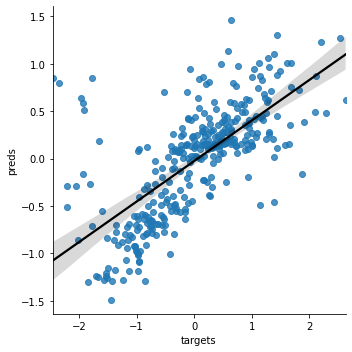

In [30]:
import seaborn as sns
plot = sns.lmplot('targets', 'preds', test_df, line_kws={'color': 'black'})
#plot = sns.jointplot('targets', 'preds', test_df, kind="kde", ylim=(-5, 5))
#plot.set()

In [4]:
test_df = pd.read_hdf('data/test_pred.df.h5', key='data')
test_df.head()

,targets,preds
item_18,-0.275983,-0.615095
item_19,-0.137607,0.104584
item_32,-0.603538,0.050036
item_36,-1.239455,-0.959906
item_47,0.357542,0.075230


In [5]:
from scipy.stats import pearsonr,spearmanr
print(pearsonr(test_df.targets, test_df.preds), spearmanr(test_df.targets, test_df.preds))

r,pv = pearsonr(test_df.targets, test_df.preds)

(0.6709500395176748, 4.4254351174799e-46) SpearmanrResult(correlation=0.7240130065196477, pvalue=8.66853750226265e-57)


/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: model_test_performamce.pdf


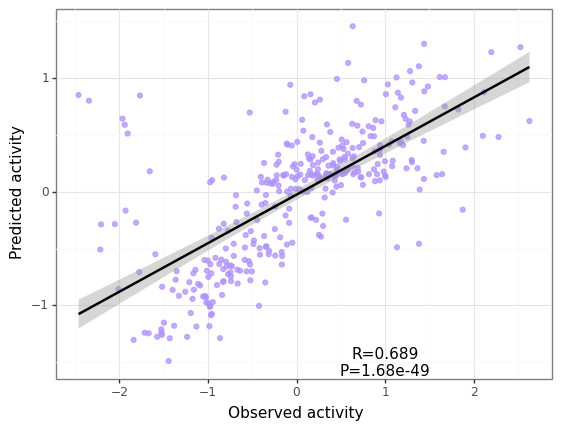

<ggplot: (-9223363300510937312)>

In [33]:
from plotnine import *
plot = (
    ggplot(test_df, aes(x='targets', y='preds')) +
    geom_point(alpha=0.75, color="#AF92FC") +
    geom_smooth(method="lm",se=True,size=1) +
    xlab("Observed activity") +
    ylab("Predicted activity") +
    annotate("text", x=1,y=-1.5, label="R={0:.3f}\nP={1:.3g}".format(r,pv))+
    theme_bw(11)
)
plot.save('model_test_performamce.pdf', width=3, height=3)
plot

## Saliency map for top sequences

In [34]:
import scipy.stats as stats

test_data_loader = DataLoader(retDataset(df.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

model.eval()
target_list = []
pred_list = []
seq_id_list = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_data_loader):
        seqid,seq_X,y = batch
        seq_X = seq_X.to(device)
        y = y.to(device)
        model = model.to(device)
        out = model(seq_X)
        pred_list.append(out[:,0].to('cpu').detach().numpy())
        target_list.append(y.to('cpu').detach().numpy())
        seq_id_list.append(seqid)
    targets = np.concatenate(target_list)
    preds = np.concatenate(pred_list)
    seq_ids = np.concatenate(seq_id_list)

print(stats.pearsonr(targets[:,0], preds), stats.spearmanr(targets[:,0], preds))

(0.7768773139122648, 0.0) SpearmanrResult(correlation=0.8218680054175455, pvalue=0.0)


In [35]:
test_df = pd.DataFrame(preds)
test_df.columns = ['preds']
test_df.index = seq_ids
test_df["predINT"] = rank_INT(test_df["preds"])
test_df.head()

,preds,predINT
item_1,-0.850169,-1.283216
item_2,-0.942167,-1.469759
item_3,-0.792342,-1.168483
item_4,-0.852928,-1.296665
item_5,-0.954795,-1.496120


In [36]:
df = df.merge(test_df, left_index=True, right_index=True)
df.head()

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length,scoreINT,preds,predINT
item_1,r1,L7,4235,86_r1_L7,1.219663,0.544209,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.287665,119,-1.205478,-0.850169,-1.283216
item_2,r1,L7,4236,86_r1_L7,0.244852,0.214515,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,-2.024137,121,-1.400132,-0.942167,-1.469759
item_3,r1,L7,4237,86_r1_L7,1.884223,1.060321,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.914735,123,-1.120598,-0.792342,-1.168483
item_4,r1,L7,4238,86_r1_L7,6.821973,3.187198,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.770400,125,-0.942509,-0.852928,-1.296665
item_5,r1,L7,4239,86_r1_L7,6.150030,2.305129,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.620828,127,-0.950524,-0.954795,-1.496120


In [37]:
df.to_csv('Eco1_ncRNAs_with_scores_processed_with_preds.tsv', sep="\t")

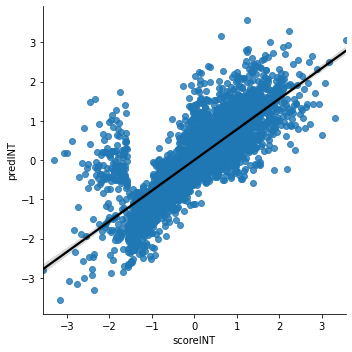

In [38]:
import seaborn as sns
plot = sns.lmplot('scoreINT', 'predINT', df, line_kws={'color': 'black'})

In [39]:
df = pd.read_csv('Eco1_ncRNAs_with_scores_processed_with_preds.tsv', sep="\t", index_col=0)
df.head()

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length,scoreINT,preds,predINT
item_1,r1,L7,4235,86_r1_L7,1.219663,0.544209,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.287665,119,-1.205478,-0.850169,-1.283216
item_2,r1,L7,4236,86_r1_L7,0.244852,0.214515,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,-2.024137,121,-1.400132,-0.942167,-1.469759
item_3,r1,L7,4237,86_r1_L7,1.884223,1.060321,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,0.914735,123,-1.120598,-0.792342,-1.168483
item_4,r1,L7,4238,86_r1_L7,6.821973,3.187198,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.770400,125,-0.942509,-0.852928,-1.296665
item_5,r1,L7,4239,86_r1_L7,6.150030,2.305129,3,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,2.620828,127,-0.950524,-0.954795,-1.496120


In [40]:
print(stats.pearsonr(df.scoreINT, df.predINT), stats.spearmanr(df.scoreINT, df.predINT))
r,pv = stats.pearsonr(df.scoreINT, df.predINT)

(0.7805249056353711, 0.0) SpearmanrResult(correlation=0.8219597767831879, pvalue=0.0)


/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: model_all_performamce.pdf


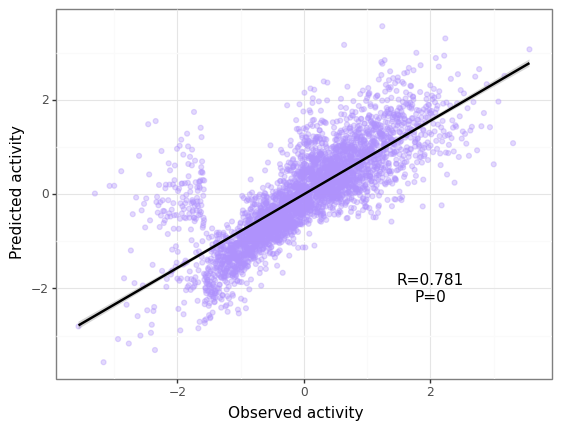

<ggplot: (-9223363300512760071)>

In [41]:
from plotnine import *
plot = (
    ggplot(df, aes(x='scoreINT', y='predINT')) +
    geom_point(alpha=0.35, color="#AF92FC") +
    geom_smooth(method="lm",se=True,size=1) +
    xlab("Observed activity") +
    ylab("Predicted activity") +
    annotate("text", x=2,y=-2, label="R={0:.3f}\nP={1:.3g}".format(r,pv))+
    theme_bw(11)
)
plot.save('model_all_performamce.pdf', width=3, height=3)
plot

In [42]:
df_selected = df.query("scoreINT>1.5 and predINT>1.5")
df_selected.head()

,synthesis,Sublibrary,fasta,prefix,"Score (enrichment/depletion relative to mean wt, wt=100)",SD,N,ncRNA,score,length,scoreINT,preds,predINT
item_53,r1,L10,5287,86_r1_L10,684.652074,25.395394,3,TTCCGTATGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACC...,9.419229,166,1.732108,1.456924,2.630058
item_57,r1,L10,5291,86_r1_L10,632.458972,48.494917,3,AAGATTCCGTATGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTC...,9.304830,174,1.664081,0.833008,1.559569
item_60,r1,L10,5294,86_r1_L10,595.574529,65.181833,3,GATAAGATTCCGTATGCGCACCCTTAGCGAGAGGTTTATCATTAAG...,9.218141,180,1.589902,0.853398,1.602983
item_61,r1,L10,5295,86_r1_L10,713.262803,22.151984,3,TGATAAGATTCCGTATGCGCACCCTTAGCGAGAGGTTTATCATTAA...,9.478292,182,1.776407,1.544565,3.000006
item_364,r2,L2,332,86_r2_L2_T6G_25A,813.640765,NaN,1,TGCGCACCCTTAGCGAGAGGTTTATCATTAAGGTCAACCTCTGGAT...,9.668250,169,2.007202,0.917514,1.709597


In [43]:
df_selected.shape

(101, 13)

In [44]:
test_data_loader = DataLoader(retDataset(df_selected.index.tolist(), score_dict, seq_dict, max_len=seq_length, left_pad_max=0), batch_size=1, shuffle=False, drop_last=False)

In [45]:
model.load_model('models/best_tuned_model.pt')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

model.train()

for batch_idx, batch in enumerate(test_data_loader):
    seqid, seq_X, y = batch
    seq_X.requires_grad = True
    seq_X = seq_X.to('cpu')
    y = y.to('cpu')
    model = model.to('cpu')
    out = model(seq_X)
    
    loss = model.loss_fn(out,y) 
    loss.backward()
    
    saliency = seq_X * seq_X.grad
    saliency = saliency.detach().numpy()
    
    saliency /= np.max(saliency)
    pwm = pd.DataFrame(-1*saliency[0].transpose(), columns=["A", "C", "G", "T"])
    
    n_logo = logomaker.Logo(pwm)
    plt.savefig("saliency_logos/{}_logo.pdf".format(seqid[0]))

## In silico mutagenesis

In [42]:
model.load_model('models/best_tuned_model.pt')

In [43]:
wt_scores_dict = dict(zip(df_selected.index.tolist(), df_selected.preds.tolist()))

In [ ]:
import pandas as pd
from collections import defaultdict

for item in df_selected.index.tolist():
    print(item)
    wt_seq = seq_dict[item]
    wt_score = wt_scores_dict[item]
    
    tmp_seq_dict = {}
    tmp_score_dict = {}
    
    tmp_seq_list = ['wt']
    tmp_seq_dict['wt'] = wt_seq
    tmp_score_dict['wt'] = 0
    for i in range(len(wt_seq)):
        tmp_seq_dict["{}-{}-{}".format(item, i, 'A')] = wt_seq[:i]+'A'+wt_seq[i+1:]
        tmp_seq_dict["{}-{}-{}".format(item, i, 'G')] = wt_seq[:i]+'G'+wt_seq[i+1:]
        tmp_seq_dict["{}-{}-{}".format(item, i, 'C')] = wt_seq[:i]+'C'+wt_seq[i+1:]
        tmp_seq_dict["{}-{}-{}".format(item, i, 'T')] = wt_seq[:i]+'T'+wt_seq[i+1:]
        
        tmp_score_dict["{}-{}-{}".format(item, i, 'A')] = 0
        tmp_score_dict["{}-{}-{}".format(item, i, 'G')] = 0
        tmp_score_dict["{}-{}-{}".format(item, i, 'C')] = 0
        tmp_score_dict["{}-{}-{}".format(item, i, 'T')] = 0
        
        tmp_seq_list.append("{}-{}-{}".format(item, i, 'A'))
        tmp_seq_list.append("{}-{}-{}".format(item, i, 'G'))
        tmp_seq_list.append("{}-{}-{}".format(item, i, 'C'))
        tmp_seq_list.append("{}-{}-{}".format(item, i, 'T'))
        
    tmp_data_loader = DataLoader(retDataset(tmp_seq_list, tmp_score_dict, tmp_seq_dict, max_len=seq_length, left_pad_max=0), batch_size=32, shuffle=False, drop_last=False)
    
    model.eval()
    target_list = []
    pred_list = []
    seq_id_list = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(tmp_data_loader):
            seqid,seq_X,y = batch
            seq_X = seq_X.to(device)
            y = y.to(device)
            model = model.to(device)
            out = model(seq_X)
            pred_list.append(out[:,0].to('cpu').detach().numpy())
            target_list.append(y.to('cpu').detach().numpy())
            seq_id_list.append(seqid)
        targets = np.concatenate(target_list)
        preds = np.concatenate(pred_list)
        seq_ids = np.concatenate(seq_id_list)
    
    seq_ids = list(seq_ids)
    preds = list(preds)
    
    seq_ids.pop(0)
    wt_score = preds.pop(0)
    
    preds = preds - wt_score
    
    diff_score_map = defaultdict(dict)
    for tmp_id, diff_score in zip(seq_ids, preds):
        dummy, pos, nt = tmp_id.split('-')
        diff_score_map[pos][nt] = diff_score
        
    tmp_df = pd.DataFrame.from_dict(diff_score_map)
    tmp_df.columns = list(wt_seq)
    tmp_df.to_csv("ISM/{}_ISM.csv".format(item))
    
    plt.figure(figsize = (18,4))
    sns.heatmap(tmp_df, vmax=0)
    plt.savefig("ISM/{}_ISM.pdf".format(item))

## Visualizing the sequence emberddings

In [45]:
test_data_loader = DataLoader(retDataset(df.index.tolist(), score_dict, seq_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

model.eval()
seq_id_list = []
embed_list = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_data_loader):
        seqid,seq_X,y = batch
        seq_X = seq_X.to(device)
        y = y.to(device)
        model = model.to(device)
        
        seq = model.conv_block_1(seq_X)
        seq = model.conv_block_2(seq)
        tmp = []
        for i in range(model.convdc):
            tmp.append(torch.flatten(model.dilations[i](seq), 1))
        res = torch.cat([torch.flatten(seq, 1)]+tmp, dim=1)
        res = model.fc[2](res)
        
        embed_list.append(res.to('cpu').detach().numpy())
        seq_id_list.append(seqid)
    embeddings = np.concatenate(embed_list)
    seq_ids = np.concatenate(seq_id_list)

In [46]:
embed_df = pd.DataFrame.from_dict(dict(zip(seq_ids, embeddings)), orient='index')
embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041918,...,0.0,0.0,0.000000,0.0,3.946422,0.851179,0.143985,1.169627,0.0,0.0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041918,...,0.0,0.0,1.178645,0.0,4.802446,0.624709,0.000000,0.677394,0.0,0.0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041918,...,0.0,0.0,0.000000,0.0,10.256680,1.750450,0.110638,1.669037,0.0,0.0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041918,...,0.0,0.0,0.000000,0.0,3.423600,0.000000,0.076247,0.517347,0.0,0.0
item_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041918,...,0.0,0.0,0.000000,0.0,0.296435,0.000000,0.000000,0.072627,0.0,0.0


In [47]:
embed_df.to_csv('Eco1_ncRNAs_fc_embeds.tsv', sep="\t")

In [48]:
import umap

trans = umap.UMAP(n_neighbors=5, random_state=42).fit(embed_df)
trans.embedding_

array([[ 3.044265 ,  1.246578 ],
       [ 3.0252278,  1.2688584],
       [ 3.0517979,  1.2557847],
       ...,
       [-5.703359 ,  3.3826585],
       [-2.9002903,  4.342083 ],
       [-2.9204297,  4.3830833]], dtype=float32)

In [49]:
umap_c = pd.DataFrame(list(zip(trans.embedding_[:, 0],trans.embedding_[:, 1],)) , columns =['UMAP1', 'UMAP2'], index=seq_ids)
umap_c.head()

,UMAP1,UMAP2
item_1,3.044265,1.246578
item_2,3.025228,1.268858
item_3,3.051798,1.255785
item_4,3.051204,1.235991
item_5,3.074662,1.198522


In [50]:
umap_c = umap_c.merge(df[["Score (enrichment/depletion relative to mean wt, wt=100)", "score", "scoreINT"]], left_index=True, right_index=True)
umap_c.head()

,UMAP1,UMAP2,"Score (enrichment/depletion relative to mean wt, wt=100)",score,scoreINT
item_1,3.044265,1.246578,1.219663,0.287665,-1.205478
item_2,3.025228,1.268858,0.244852,-2.024137,-1.400132
item_3,3.051798,1.255785,1.884223,0.914735,-1.120598
item_4,3.051204,1.235991,6.821973,2.770400,-0.942509
item_5,3.074662,1.198522,6.150030,2.620828,-0.950524


In [51]:
umap_c.to_csv("Eco1_ncRNAs_fc_embeds_umap.tsv", sep="\t")

/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Eco1_ncRNAs_fc_embeds_umap.pdf


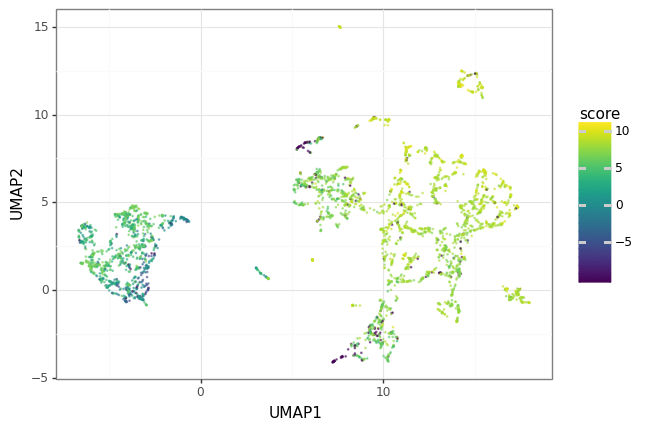

<ggplot: (-9223363247169248568)>

In [52]:
from plotnine import *

plot = (
    ggplot(umap_c, aes(x="UMAP1", y="UMAP2", color="score")) +
    geom_point(alpha=0.5, size=0.1) +
    theme_bw(11)
)
plot.save(filename = 'Eco1_ncRNAs_fc_embeds_umap.pdf', height=5, width=5, units = 'in')
plot